# Machine learning Random Forest models

## Load the dataset

In [1]:
import pandas as pd
import seaborn
import numpy as np
from pylab import *

## Read the csv with the channels ordered by significance

#### Select the patient and the directories and the number of significant channels to train the model

In [4]:
nchannels = 1
patient = '\chb01'
datasetdir = r'C:\Users\Mario\Documents\Master\TFM\Codigo\Jupiter\EEG_ML\DataSetCreation\DatasetsDetection'
fdir = datasetdir + patient + 'features.h5'

#### Read the csv file and stract the ordered channels

In [5]:
channelsdf = pd.read_csv(datasetdir + patient + '_channel_order.csv', delimiter=',')
list_of_rows = [list(row) for row in channelsdf.values]

In [6]:
channel_score_dict = {}
for i, elem in enumerate(list_of_rows[0]):
    channel_score_dict[elem] = i
    
for row, rowlist in enumerate(list_of_rows[1:]):
    for i, elem in enumerate(rowlist):
        channel_score_dict[elem] = channel_score_dict[elem] + i
        
sorted_channels = sorted(channel_score_dict, key=channel_score_dict.get)
significant_channels = sorted_channels[:nchannels]

In [7]:
significant_channels

['FT9-FT10']

### Read Dataset

In [8]:
df = pd.read_hdf(datasetdir + patient + 'features.h5', key = 'fullpatient')

### Extract the desired channels

In [9]:
df = df[(df['channel'] == significant_channels[0])]
df = df.drop(['channel'], axis=1)

In [10]:
df[df['seizure'] == True]

,mean,variance,skewness,kurtosis,std,zero_crossings,peak2peak,total_energy,delta,theta,alpha,beta,gamma,seizure
361,0.163932,3154.293104,0.132924,-0.368701,56.163094,62.0,294.850406,5181.014869,2212.371990,2262.965153,884.035069,164.850940,97.218538,True
362,-3.363003,12616.597818,0.257843,1.596332,112.323630,50.0,734.158928,25164.604639,21904.924142,3090.354751,582.918383,202.580573,156.068159,True
363,-2.393524,33270.889695,-0.220567,-0.275883,182.403097,26.0,936.005650,71700.884842,64830.573651,6569.391804,561.658893,482.070473,420.365466,True
364,4.462458,35728.106631,-0.498677,-0.470689,189.018800,23.0,936.005650,72582.043554,67424.964543,4927.892459,624.006343,496.495812,480.370363,True
365,5.919438,29569.069241,-0.502099,-0.464093,171.956591,30.0,823.965651,64397.121875,61265.210019,2762.673411,605.275561,364.707896,249.885274,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4481,-3.487511,24526.576713,0.412570,-0.148388,156.609632,27.0,803.120688,47656.487313,43701.764134,3298.074941,1229.692259,844.388084,127.387650,True
4482,5.956805,35631.452117,-0.163537,-0.522764,188.762952,31.0,937.415190,69748.730243,56984.558758,11650.915016,3174.240999,1612.860894,158.779045,True
4483,8.543069,30012.773601,-0.197092,0.055967,173.241951,37.0,953.473278,54926.729283,37745.405525,16623.534404,2917.281057,1837.849381,180.535644,True
4484,-9.525658,17129.983943,0.212385,0.092414,130.881565,40.0,735.692634,34387.122868,26977.769588,7388.436007,1560.852934,1541.413992,132.844465,True


<Figure size 432x288 with 0 Axes>

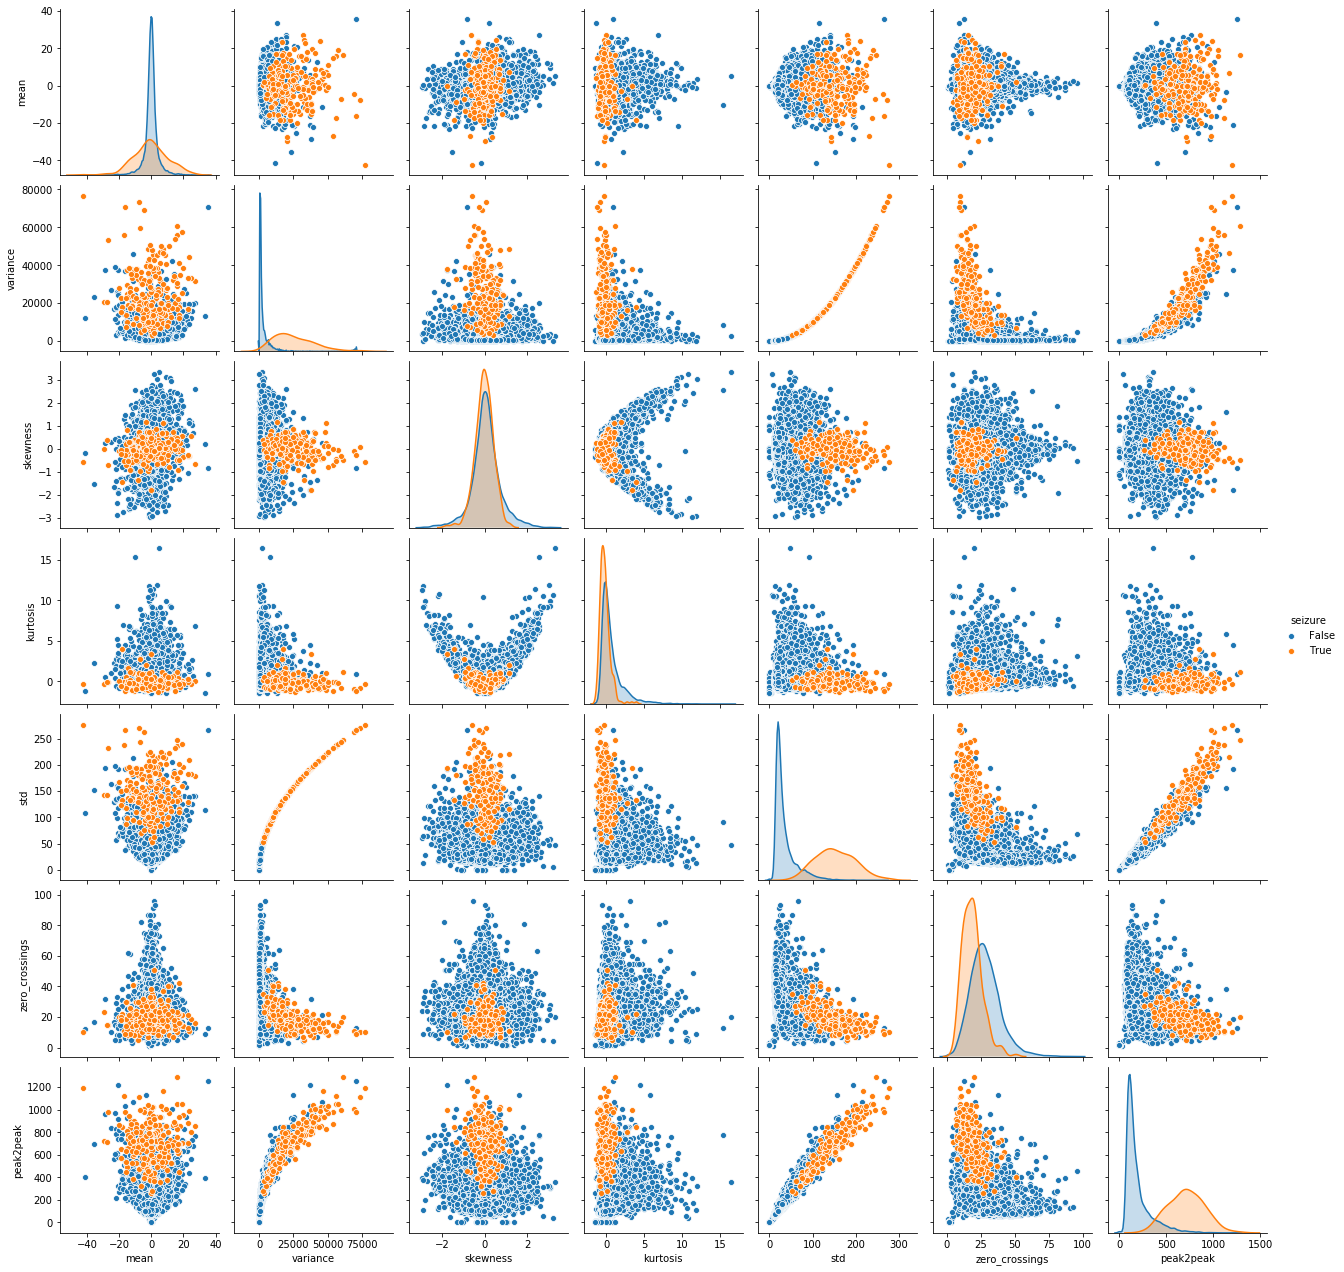

<Figure size 432x288 with 0 Axes>

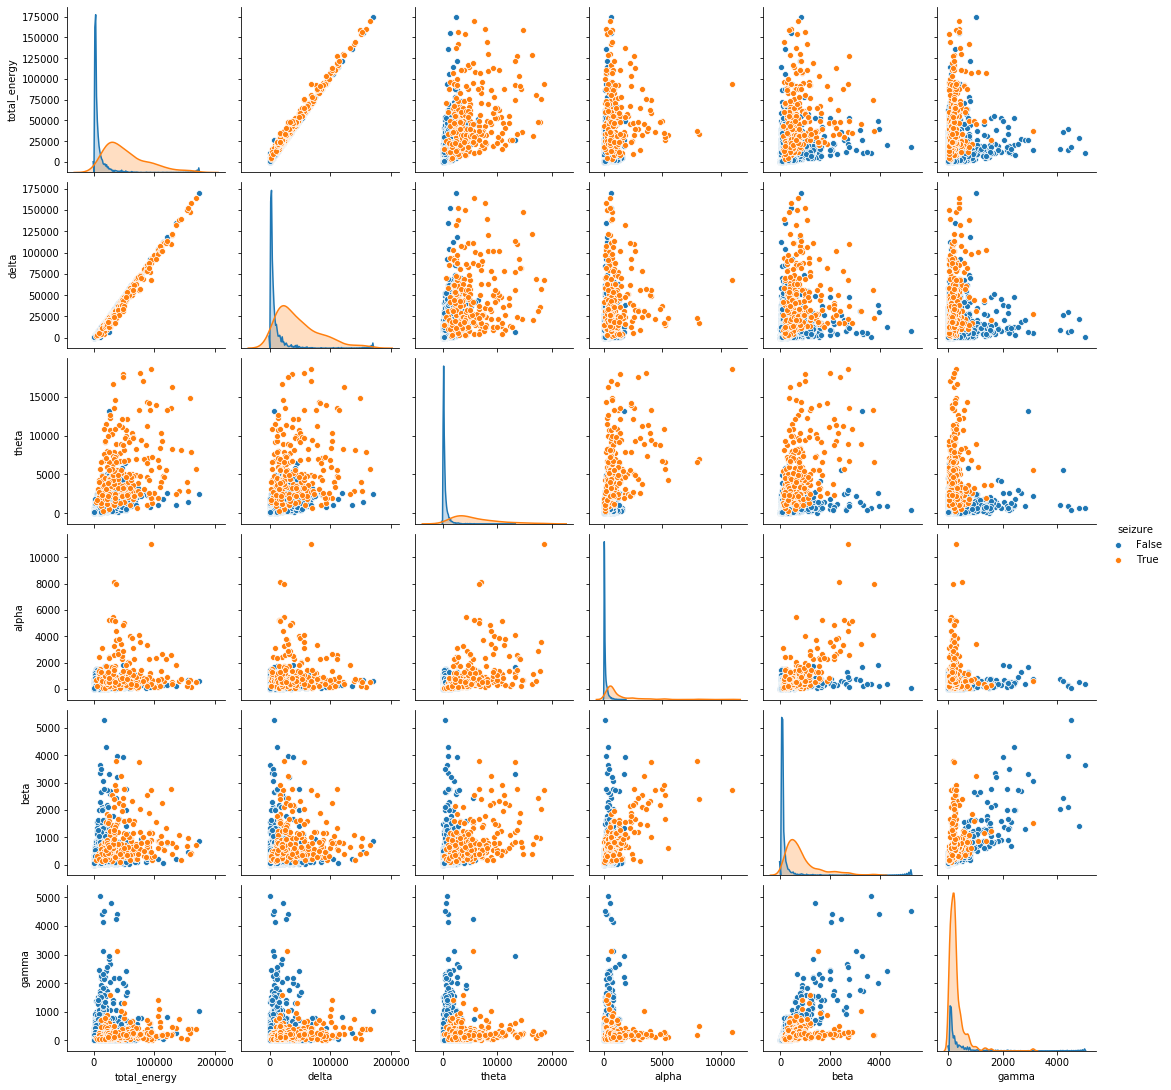

In [9]:
plt.figure()
seaborn.pairplot(df[['mean', 'variance', 'skewness', 'kurtosis', 'std', 'zero_crossings', 'peak2peak', 'seizure']], hue="seizure")
plt.show()
    
plt.figure()
seaborn.pairplot(df[['total_energy', 'delta', 'theta', 'alpha', 'beta', 'gamma', 'seizure']], hue="seizure")
plt.show()
    

## Splitting 80-20

In [55]:
def split_train_test(data, test_ratio):
    data = data.sample(frac=1)
    test_set_size = int(len(data) * test_ratio)
    test_set = data.iloc[:test_set_size]
    train_set = data.iloc[test_set_size:]
    return train_set, test_set

# It is important that there is the moreless the same percentage of seizures in training and test sets
# Separate in 2 subsets
df_seizures = df[df['seizure'] == True]
df_normal = df[df['seizure'] == False]

train_seizures, test_seizures = split_train_test(df_seizures, 0.2)
train_normal, test_normal = split_train_test(df_normal, 0.2)

df_train = pd.concat([train_normal, train_seizures], axis=0).reset_index()
x_train, y_train = df_train[df_train.columns.difference(['seizure'])], df_train["seizure"]
df_test = pd.concat([test_normal, test_seizures], axis=0).reset_index()
x_test, y_test = df_test[df_test.columns.difference(['seizure'])], df_test["seizure"]

np.random.seed(42)
shuffle_index = np.random.permutation(len(x_train))
x_train, y_train = x_train.iloc[shuffle_index], y_train.iloc[shuffle_index]


## Random Forest Classifiers

## First contact

In [56]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, average_precision_score

In [57]:
knn_clf = Pipeline((
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=3, n_jobs = -1))
))

In [58]:
knn_clf.fit(x_train, y_train)

y_train_pred = cross_val_predict(knn_clf, x_train, y_train, cv=3, n_jobs = 12)

In [59]:
print('Precision score: ' + str(precision_score(y_train, y_train_pred)))
print('Recall score: ' + str(recall_score(y_train, y_train_pred)))
print('F1 score: ' + str(f1_score(y_train, y_train_pred)))

Precision score: 0.9236111111111112
Recall score: 0.6303317535545023
F1 score: 0.7492957746478873


In [60]:
y_test_pred = knn_clf.predict(x_test)

print('Precision score: ' + str(precision_score(y_test, y_test_pred)))
print('Recall score: ' + str(recall_score(y_test, y_test_pred)))
print('F1 score: ' + str(f1_score(y_test, y_test_pred)))

Precision score: 0.8333333333333334
Recall score: 0.7692307692307693
F1 score: 0.8


## Grid search

In [62]:
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report

In [79]:
pipe_svc = Pipeline((
    ("scl", StandardScaler()),
    ("clf", KNeighborsClassifier())
))

param_grid = [{'clf__n_neighbors': list(range(11)), 'clf__p': [1,2], 'clf__weights': ['uniform', 'distance']}]

gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid, cv = 5, scoring='roc_auc', return_train_score=True, n_jobs = -1)
gs.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=(('scl',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))),
                                verbose=False),
             i

In [80]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=10, p=1,
                                      weights='distance'))],
         verbose=False)

In [81]:
y_true, y_pred = y_test, gs.predict(x_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99      1440
        True       0.97      0.60      0.74        52

    accuracy                           0.99      1492
   macro avg       0.98      0.80      0.87      1492
weighted avg       0.99      0.99      0.98      1492



# When using 2 channels

In [94]:
patient = '\chb01'
dsdir = r'C:\Users\Mario\Documents\Master\TFM\Codigo\Jupiter\EEG_ML\Datasets'
fdir = dsdir + patient + 'selectionfeatures' + '2' + '.h5'

df = pd.read_hdf(fdir, key = 'fullpatient')

## Splitting 80-20

In [10]:
# It is important that there is the moreless the same percentage of seizures in training and test sets
# Separate in 2 subsets

df_seizures = df[df['seizure'] == True]
df_normal = df[df['seizure'] == False]

def split_train_test(data, test_ratio):
    test_set_size = int(len(data) * test_ratio)
    test_set = data.iloc[:test_set_size]
    train_set = data.iloc[test_set_size:]
    return train_set, test_set

train_seizures, test_seizures = split_train_test(df_seizures, 0.2)
train_normal, test_normal = split_train_test(df_normal, 0.2)

df_train = pd.concat([train_normal, train_seizures], axis=0).reset_index()
x_train, y_train = df_train[df_train.columns.difference(['seizure'])], df_train["seizure"]
df_test = pd.concat([test_normal, test_seizures], axis=0).reset_index()
x_test, y_test = df_test[df_test.columns.difference(['seizure'])], df_test["seizure"]

np.random.seed(42)
shuffle_index = np.random.permutation(len(x_train))
x_train, y_train = x_train.iloc[shuffle_index], y_train.iloc[shuffle_index]


## SVM Classifiers

In [95]:
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [112]:
svm_clf = Pipeline((
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=0.1, loss="hinge", max_iter = 100000000))
))

In [113]:
svm_clf.fit(x_train, y_train)

y_train_pred = cross_val_predict(svm_clf, x_train, y_train, cv=3)

In [114]:
print('Precision score: ' + str(precision_score(y_train, y_train_pred)))
print('Recall score: ' + str(recall_score(y_train, y_train_pred)))
print('F1 score: ' + str(f1_score(y_train, y_train_pred)))

Precision score: 0.9082397003745318
Recall score: 0.6918687589158345
F1 score: 0.785425101214575


In [115]:
y_test_pred = cross_val_predict(svm_clf, x_test, y_test, cv=3)

print('Precision score: ' + str(precision_score(y_test, y_test_pred)))
print('Recall score: ' + str(recall_score(y_test, y_test_pred)))
print('F1 score: ' + str(f1_score(y_test, y_test_pred)))

Precision score: 0.8851351351351351
Recall score: 0.7485714285714286
F1 score: 0.8111455108359132


In [33]:
y_test_pred = cross_val_predict(svm_clf, x_test, y_test, cv=3)

print('Precision score: ' + str(precision_score(y_test, y_test_pred)))
print('Recall score: ' + str(recall_score(y_test, y_test_pred)))
print('F1 score: ' + str(f1_score(y_test, y_test_pred)))

Precision score: 0.05280665280665281
Recall score: 0.7257142857142858
F1 score: 0.09844961240310078
